**ML - Aprendizaje No Supervisado**

**Configuración e importaciones**: Se cargan librerías necesarias (p. ej., NumPy/Pandas para manejo de datos, scikit‑learn para modelos no supervisados y métricas, y Matplotlib/Seaborn para gráficos).

**Carga de datos**: Se importa el dataset desde archivo/URL a un `DataFrame` de Pandas.

**dataset (UCI HAR – Human Activity Recognition Using Smartphones):**: datos de reconocimiento de actividades humanas capturado con un smartphone Samsung Galaxy S II



In [117]:
# ==== IMPORTS ====
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ==== 1) Cargar datos ESCALADOS ====
df = pd.read_csv("har_unlabeled_scaled.csv")
print("Datos cargados:", df.shape)

# ==== 2) (Opcional) Subset interpretable de columnas ====
keep_regex = (
    r"^(?:"
    r"tBodyAcc_(?:mean|std)_[XYZ]|tBodyAccMag_(?:mean|std)|"
    r"tBodyGyro_(?:mean|std)_[XYZ]|tBodyGyroMag_(?:mean|std)|"
    r"fBodyAcc_meanFreq_[XYZ]|fBodyAccMag_meanFreq|"
    r"fBodyGyro_meanFreq_[XYZ]|fBodyGyroMag_meanFreq|"
    r"angle_.+"
    r")$"
)
cols_keep = [c for c in df.columns if re.match(keep_regex, c)]

if cols_keep:
    print(f"Subset seleccionado: {len(cols_keep)} columnas")
    X0 = df[cols_keep].to_numpy()
else:
    print("No se encontraron columnas del patrón; usando TODAS las columnas.")
    X0 = df.to_numpy()

Datos cargados: (10299, 561)
Subset seleccionado: 30 columnas


In [118]:

print("Dimensiones:", df.shape)         # (filas, columnas)
df.head(10)                             # primeras 10 filas


Dimensiones: (10299, 561)


,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,fBodyBodyGyroJerkMag_meanFreq,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,angle_tBodyAccMean_gravity,angle_tBodyAccJerkMean_gravityMean,angle_tBodyGyroMean_gravityMean,angle_tBodyGyroJerkMean_gravityMean,angle_X_gravityMean,angle_Y_gravityMean,angle_Z_gravityMean
0,0.210534,-0.068703,-0.452195,-0.883335,-0.945431,-0.744387,-0.874687,-0.944877,-0.773250,-0.868773,...,-0.819093,-0.000264,-0.299902,-0.357898,0.062039,-0.782988,-0.019034,-0.674432,0.382008,-0.016151
1,0.060209,0.035902,-0.275222,-0.890098,-0.929817,-0.860322,-0.883627,-0.927796,-0.858859,-0.884263,...,0.127803,-0.925905,-0.789555,0.135993,-0.022538,-1.217721,1.470315,-0.681360,0.383148,-0.000121
2,0.078460,-0.046427,-0.085548,-0.883565,-0.913597,-0.906457,-0.878093,-0.904569,-0.908437,-0.876139,...,1.172610,-0.287824,-0.461181,-0.375145,0.391762,0.134732,1.686961,-0.689471,0.384289,0.019214
3,0.071375,-0.227794,-0.270741,-0.885188,-0.946015,-0.935521,-0.879495,-0.943979,-0.938095,-0.876139,...,1.132149,0.566244,0.436736,-0.132194,-0.034739,1.010012,-0.982261,-0.688915,0.388536,0.024624
4,0.033738,0.031617,-0.121379,-0.889855,-0.940846,-0.935041,-0.882451,-0.937622,-0.940948,-0.883152,...,-0.158720,-0.165153,-0.263958,0.343504,0.268015,1.096950,-1.251689,-0.687381,0.399066,0.038649
5,0.042167,0.205936,0.071426,-0.888023,-0.960177,-0.947276,-0.880773,-0.959403,-0.953749,-0.883152,...,-0.434967,-0.770866,-0.734888,0.222616,-0.326566,0.417681,-0.740604,-0.690837,0.397990,0.045216
6,0.075514,-0.051103,-0.020688,-0.887079,-0.913595,-0.916798,-0.879261,-0.909585,-0.922591,-0.880400,...,0.077968,0.254210,0.172516,-0.655008,-0.521457,-0.004944,-0.371931,-0.695764,0.389306,0.041930
7,0.045623,-0.343282,-0.309923,-0.886254,-0.912681,-0.913001,-0.878009,-0.910032,-0.922254,-0.880400,...,0.039417,0.675504,0.634705,-0.084953,1.321915,-0.940592,0.983200,-0.693547,0.394572,0.045776
8,0.043566,-0.107934,-0.223000,-0.888008,-0.901719,-0.918170,-0.880696,-0.891285,-0.925756,-0.879678,...,0.763269,0.091168,0.144778,0.015595,0.175009,-0.408979,0.262026,-0.687589,0.411609,0.062928
9,0.092251,0.209641,0.053929,-0.882252,-0.924736,-0.924543,-0.875395,-0.925212,-0.928921,-0.878619,...,0.573174,1.992978,2.455309,-0.084067,-0.291450,-0.812378,-0.126769,-0.688221,0.415956,0.073887


**Reducción de dimensionalidad**: Se aplica PCA/SVD/UMAP/t‑SNE para comprimir la información y facilitar visualizaciones o mejorar la estabilidad del clustering.


In [119]:
# ==== 3) PCA para compactar (≈95% var) ====
pca_feat = PCA(n_components=0.95, random_state=42)
Xr = pca_feat.fit_transform(X0)
print("PCs usados:", Xr.shape[1], "— varianza retenida:",
      round(pca_feat.explained_variance_ratio_.sum(), 4))



PCs usados: 18 — varianza retenida: 0.9559



**Clustering K‑Means**: Se ajusta un modelo K‑Means para agrupar ejemplos según similitud en el espacio de características.

**Método del codo (WCSS/Inertia)**: Se prueba un rango de k para localizar un ‘codo’ donde el beneficio marginal decrece y elegir k adecuado.

**Índice de Silhouette**: Se evalúa la separación y compacidad de los clústeres; valores cercanos a 1 indican mejor separación.


In [120]:
# ==== 4) Buscar k automáticamente (silhouette + codo) ====
k_min, k_max = 2, 10
scores, inertias, models = [], [], []

for k in range(k_min, k_max + 1):
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(Xr)
    # si va lento, usa sample_size=3000
    s = silhouette_score(Xr, labels)
    scores.append(s); inertias.append(km.inertia_); models.append((k, km, labels))

scores_arr = np.array(scores); inertias_arr = np.array(inertias)
best_idxs = np.flatnonzero(scores_arr == scores_arr.max())
best_idx = best_idxs[np.argmin(inertias_arr[best_idxs])] if len(best_idxs) > 1 else best_idxs[0]

best_k, best_model, best_labels = models[best_idx]
print(f"Mejor k (auto): {best_k} | silhouette={scores[best_idx]:.4f}")


Mejor k (auto): 2 | silhouette=0.3159


**Persistencia**: Se guardan datasets transformados y/o modelos entrenados para uso posterior.

In [121]:
# ==== 7) Guardar etiquetas ====
pd.Series(best_labels, name="cluster").to_csv("har_clusters_auto_k.csv", index=False)
print("Etiquetas guardadas en: har_clusters_auto_k.csv")

Etiquetas guardadas en: har_clusters_auto_k.csv


**Visualización**: Se generan gráficos (dispersión, histogramas, codo, silhouette, etc.) para interpretar resultados.

In [122]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=120, linewidths=2,
                edgecolor=circle_color, facecolor='none', zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=60, linewidths=2,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=400,
                             show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(
        np.linspace(mins[0], maxs[0], resolution),
        np.linspace(mins[1], maxs[1], resolution)
    )
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Contornos y relleno en 2D
    plt.contourf(xx, yy, Z, cmap="Pastel2", alpha=0.8)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.5)

    plot_data(X)
    if show_centroids and hasattr(clusterer, "cluster_centers_"):
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=12)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=12, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.tight_layout()




**Clustering K‑Means**: Se ajusta un modelo K‑Means para agrupar ejemplos según similitud en el espacio de características.

**Visualización**: Se generan gráficos (dispersión, histogramas, codo, silhouette, etc.) para interpretar resultados.

PC1=50.7%  PC2=6.2%


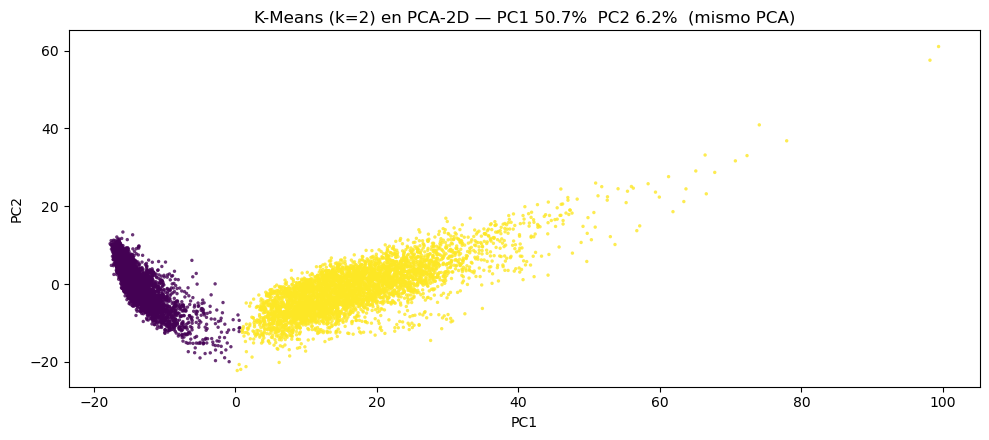

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans



# 2) Un SOLO PCA (fijamos random_state)
pca2 = PCA(n_components=2, random_state=42)
X2 = pca2.fit_transform(X)
print(f"PC1={pca2.explained_variance_ratio_[0]*100:.1f}%  PC2={pca2.explained_variance_ratio_[1]*100:.1f}%")

def plot_kmeans_k(k, title_extra=""):
    km = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(X2)  # ENTRENAR EN EL MISMO 2D
    labels = km.labels_
    plt.figure(figsize=(10,4.5))
    plt.scatter(X2[:,0], X2[:,1], c=labels, s=6, alpha=0.8, linewidths=0)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.title(f"K-Means (k={k}) en PCA-2D — PC1 {pca2.explained_variance_ratio_[0]*100:.1f}%  "
              f"PC2 {pca2.explained_variance_ratio_[1]*100:.1f}% {title_extra}")
    plt.tight_layout(); plt.show()
    return km

# 3) Mismo plano, dos ks:
km2  = plot_kmeans_k(best_k,  " (mismo PCA)")




**Clustering K‑Means**: Se ajusta un modelo K‑Means para agrupar ejemplos según similitud en el espacio de características.

**Visualización**: Se generan gráficos (dispersión, histogramas, codo, silhouette, etc.) para interpretar resultados.

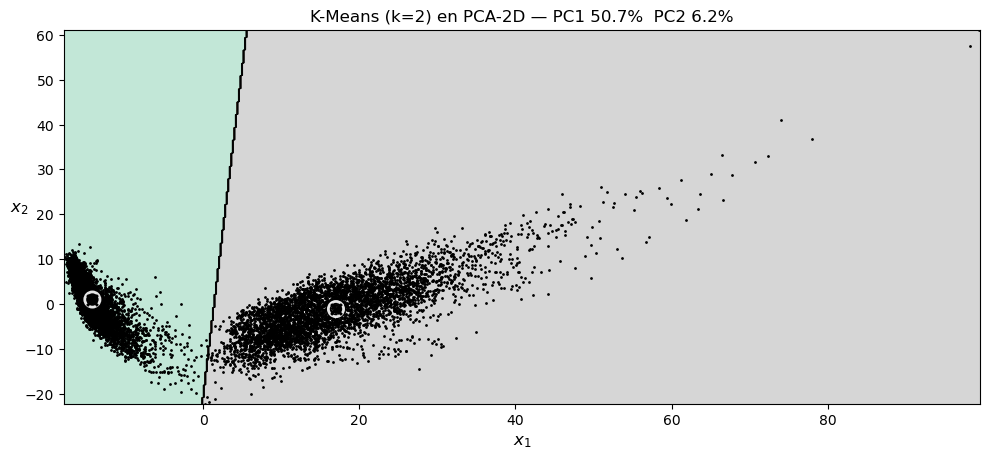

In [124]:
# 2) Reducir a 2D para visualizar y CLUSTERIZAR en el mismo espacio
pca2 = PCA(n_components=2, random_state=42)
X2 = pca2.fit_transform(df.to_numpy())

# 3) Entrenar K-Means (si quieres, pon k=2 o usa el k que elegiste automáticamente)
k = best_k
km = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(X2)

# 4) Dibujar fronteras + puntos + centroides
plt.figure(figsize=(10, 4.5))
plot_decision_boundaries(km, X2, resolution=600)
plt.title(f"K-Means (k={k}) en PCA-2D — PC1 {pca2.explained_variance_ratio_[0]*100:.1f}%  "
          f"PC2 {pca2.explained_variance_ratio_[1]*100:.1f}%")
plt.show()

Como se puede ver en la grafica, me muestra los clusters :  clúster 0 = “estático” (baja energía/variabilidad), clúster 1 = “dinámico” (alta) 

**Método del codo (WCSS/Inertia)**: Se prueba un rango de k para localizar un ‘codo’ donde el beneficio marginal decrece y elegir k adecuado.

**Índice de Silhouette**: Se evalúa la separación y compacidad de los clústeres; valores cercanos a 1 indican mejor separación.

**Visualización**: Se generan gráficos (dispersión, histogramas, codo, silhouette, etc.) para interpretar resultados.

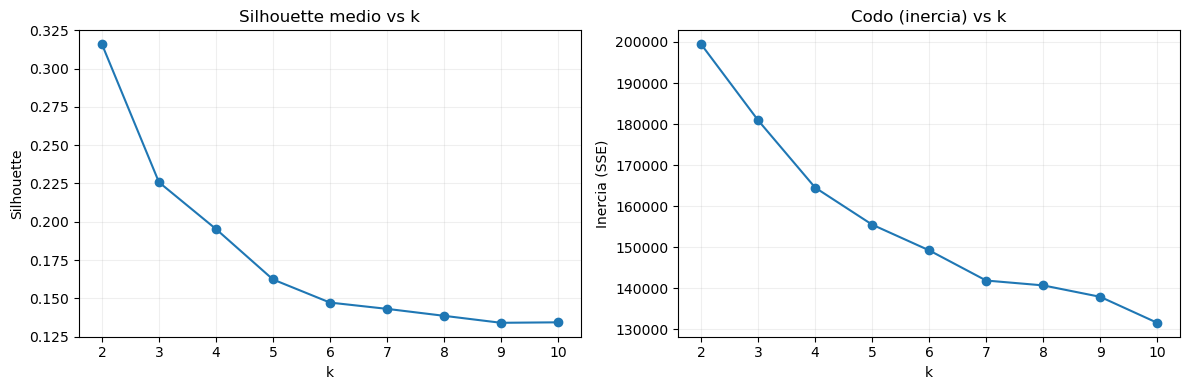

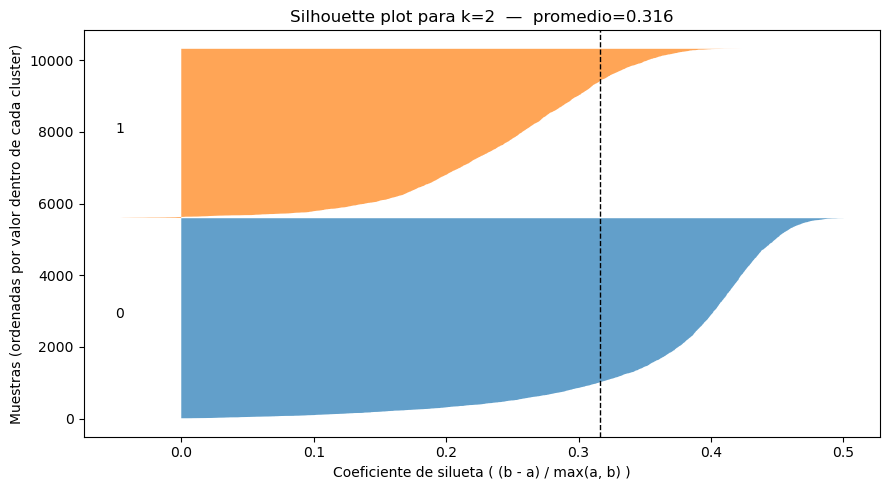

In [125]:
from sklearn.metrics import silhouette_score, silhouette_samples
# 4) Gráfica: Silhouette vs k + (opcional) Codo por referencia
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(ks, sil_scores, marker="o"); ax[0].set_xlabel("k"); ax[0].set_ylabel("Silhouette")
ax[0].set_title("Silhouette medio vs k"); ax[0].grid(alpha=.2)
ax[1].plot(ks, inertias, marker="o"); ax[1].set_xlabel("k"); ax[1].set_ylabel("Inercia (SSE)")
ax[1].set_title("Codo (inercia) vs k"); ax[1].grid(alpha=.2)
plt.tight_layout(); plt.show()

# 5) Silhouette plot del k ganador (muestra la distribución por cluster)
km_best   = KMeans(n_clusters=best_k, n_init="auto", random_state=42).fit(Xr)
labels    = km_best.labels_
sil_samps = silhouette_samples(Xr, labels)

y_lower = 10
plt.figure(figsize=(9,5))
for i in range(best_k):
    ith_vals = sil_samps[labels == i]
    ith_vals.sort()
    size_i = ith_vals.shape[0]
    y_upper = y_lower + size_i
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_vals, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_i, str(i))
    y_lower = y_upper + 10  # espacio entre grupos

plt.axvline(x=np.mean(sil_samps), color="k", linestyle="--", linewidth=1)
plt.xlabel("Coeficiente de silueta ( (b - a) / max(a, b) )")
plt.ylabel("Muestras (ordenadas por valor dentro de cada cluster)")
plt.title(f"Silhouette plot para k={best_k}  —  promedio={np.mean(sil_samps):.3f}")
plt.tight_layout()
plt.show()

k=2 está bien justificado: máximo silhouette, bandas mayormente positivas, pocos puntos en frontera/negativos.

Los clústeres representan dos regímenes claros (en HAR: estático vs dinámico).

**Limpieza/transformación**: Se realiza preprocesamiento (eliminación de columnas, manejo de nulos, conversión de tipos o combinación de tablas).

In [126]:
# A) Cargar tus datos escalados (X únicamente)
df = pd.read_csv("har_unlabeled_scaled.csv")
X = df.to_numpy().astype(np.float32)

**K-Means para aprendizaje semi-supervisado.**

**Reducción de dimensionalidad**: Se aplica PCA/SVD/UMAP/t‑SNE para comprimir la información y facilitar visualizaciones o mejorar la estabilidad del clustering.

**Clustering K‑Means**: Se ajusta un modelo K‑Means para agrupar ejemplos según similitud en el espacio de características.



In [127]:
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_samples
# B) PCA para compactar (rápido y estable). 50 PCs ≈ estándar en este paso.
pca50 = PCA(n_components=50, random_state=42)
X50 = pca50.fit_transform(X)

# C) K-Means con k “grande” (p.ej. 50) para descubrir micro-grupos
k_proto = 50
kmeans = KMeans(n_clusters=k_proto, n_init=20, random_state=42)
labels50 = kmeans.fit_predict(X50)

In [128]:
# D) Representantes (prototipos) por clúster:
#    - Opción 1: más cercano al centroide
closest_idx, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X50)
#    - Opción 2 (alternativa): mayor silhouette dentro del clúster
sil = silhouette_samples(X50, labels50)  # sólo si quieres otro criterio

# E) Tabla de prototipos (1 por clúster)
protos_df = pd.DataFrame({
    "cluster": np.arange(k_proto),
    "row_index": closest_idx,
    "silhouette": sil[closest_idx]
}).sort_values("cluster").reset_index(drop=True)

protos_df.to_csv("har_prototypes_k50.csv", index=False)
print("Prototipos guardados en har_prototypes_k50.csv (1 por clúster).")


Prototipos guardados en har_prototypes_k50.csv (1 por clúster).


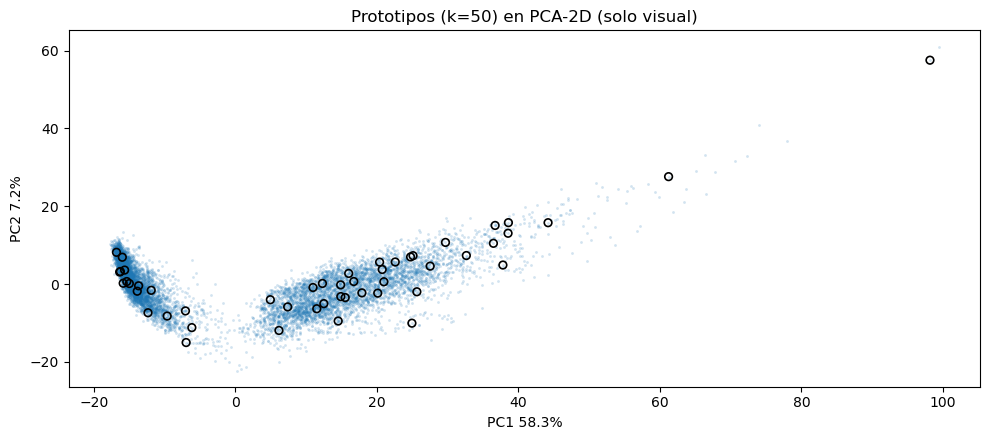

In [129]:
# F) Visualización: proyectar a 2D solo para ver (no para entrenar)
pca2 = PCA(n_components=2, random_state=42)
X2 = pca2.fit_transform(X50)

plt.figure(figsize=(10,4.5))
plt.scatter(X2[:,0], X2[:,1], s=4, alpha=0.2, linewidths=0)
# resalta los prototipos
pp = protos_df["row_index"].to_numpy()
plt.scatter(X2[pp,0], X2[pp,1], s=30, edgecolor="k", facecolor="none", linewidths=1.2)
plt.title(f"Prototipos (k={k_proto}) en PCA-2D (solo visual)")
plt.xlabel(f"PC1 {pca2.explained_variance_ratio_[0]*100:.1f}%"); plt.ylabel(f"PC2 {pca2.explained_variance_ratio_[1]*100:.1f}%")
plt.tight_layout(); plt.show()

Esa figura muestra las 50 prototipos. de K= 50.

**Aprendizaje Activo**

In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# ---- Config y datos (ajusta ROOT si hace falta) ----
ROOT = Path(r"C:\Users\LENOVO\OneDrive\Desktop\python\datasets\UCI HAR Dataset\UCI HAR Dataset")
CSV  = "har_unlabeled_scaled.csv"
SEED = 42
BATCH = 50
ROUNDS = 10
INIT_PER_CLASS = 3

In [131]:
# Cargar X escalado y etiquetas (para oráculo simulado)
X_all = pd.read_csv(CSV).to_numpy().astype(np.float32)
n_train = 7352
X_tr_raw, X_te_raw = X_all[:n_train], X_all[n_train:]
y_tr = np.loadtxt(ROOT/"train"/"y_train.txt", dtype=int)
y_te = np.loadtxt(ROOT/"test"/"y_test.txt",  dtype=int)

# Reducción ligera (PCA) para estabilidad/velocidad
pca = PCA(n_components=50, random_state=SEED)
X_tr = pca.fit_transform(X_tr_raw)
X_te = pca.transform(X_te_raw)

In [132]:
# Semilla inicial pequeña (INIT_PER_CLASS por clase)
rng = np.random.default_rng(SEED)
classes = np.unique(y_tr)
seed_idx = np.concatenate([rng.choice(np.where(y_tr==c)[0], INIT_PER_CLASS, replace=False) for c in classes])
pool_idx = np.setdiff1d(np.arange(len(y_tr)), seed_idx)

L_X, L_y = X_tr[seed_idx], y_tr[seed_idx]
U_X, U_y = X_tr[pool_idx], y_tr[pool_idx]

clf = LogisticRegression(max_iter=400, n_jobs=-1, random_state=SEED)


In [133]:
sizes, accs = [], []
for r in range(ROUNDS+1):
    clf.fit(L_X, L_y)
    accs.append(accuracy_score(y_te, clf.predict(X_te)))
    sizes.append(len(L_y))
    if r == ROUNDS:
        break
    # Uncertainty = least confidence
    proba = clf.predict_proba(U_X)
    score = 1.0 - proba.max(axis=1)
    ask = np.argsort(score)[-BATCH:]  # los más inciertos
    # Oráculo devuelve y
    L_X = np.vstack([L_X, U_X[ask]])
    L_y = np.hstack([L_y, U_y[ask]])
    keep = np.ones(len(U_X), bool); keep[ask] = False
    U_X, U_y = U_X[keep], U_y[keep]

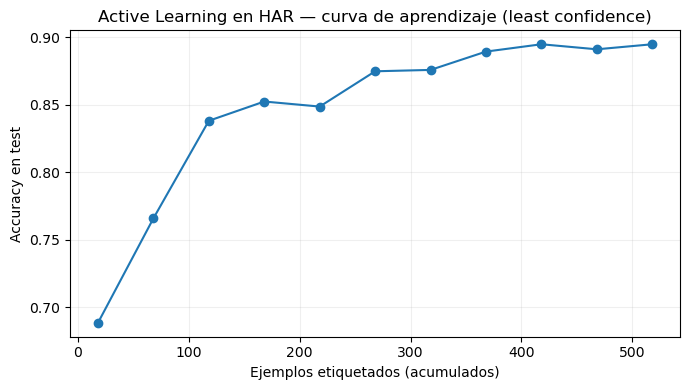

Puntos graficados (sizes): [18, 68, 118, 168, 218, 268, 318, 368, 418, 468, 518]
Accuracies correspondientes: [0.6885, 0.7659, 0.8381, 0.8524, 0.8487, 0.8748, 0.8758, 0.8894, 0.8948, 0.8911, 0.8948]


In [134]:
# Graficar
plt.figure(figsize=(7,4))
plt.plot(sizes, accs, marker="o")
plt.xlabel("Ejemplos etiquetados (acumulados)")
plt.ylabel("Accuracy en test")
plt.title("Active Learning en HAR — curva de aprendizaje (least confidence)")
plt.grid(alpha=.2)
plt.tight_layout(); plt.show()

print("Puntos graficados (sizes):", sizes)
print("Accuracies correspondientes:", [round(a,4) for a in accs])